In [151]:
import torch.nn as nn
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import transforms
from utils import *
from torch.utils.data import DataLoader
from models import *
import random
from collections import Counter
from collections import OrderedDict
import seaborn as sns
import copy

cos = nn.CosineSimilarity(dim=0, eps=1e-9)
device = "cuda"

# study 1 model's training with the new loss function with dist limits

# adjustable parameters
alpha_d = 100 # IID
local_ep = 10 
n_clients = 50 # dataset size for one client
mali_local_ep = 10
global attack 
attack = "untargeted" #"backdoor", "tlp", "ut"
model_name = "ConvNet" # "resnet8", "ConvNet"
num_classes = 10
dataset ="fmnist"

In [152]:
def filter_trainable_state_dict(model):
    """
    Filters model.state_dict() to retain only parameters that are in model.parameters().

    Args:
        model (torch.nn.Module): The model whose state_dict needs filtering.

    Returns:
        dict: Filtered state dictionary containing only trainable parameters.
    """
    param_names = {name for name, _ in model.named_parameters()}
    return {k: v for k, v in model.state_dict().items() if k in param_names}

# # Example usage
# model = nn.Sequential(
#     nn.Linear(10, 5),
#     nn.BatchNorm1d(5),  # This has buffers (running_mean, running_var) in state_dict but not in parameters
#     nn.Linear(5, 2)
# )

# filtered_state_dict = filter_trainable_state_dict(model)
# print(filtered_state_dict.keys())  # Only includes trainable parameters


In [153]:
def cos_dist(w1, w2):
    """Compute cosine similarity between two flattened weight tensors"""
    w1_flat, w2_flat = torch.cat([p.view(-1) for p in w1]), torch.cat([p.view(-1) for p in w2])
    return 1 - torch.dot(w1_flat, w2_flat) / (torch.norm(w1_flat) * torch.norm(w2_flat))

def get_delta_cos(model1, model2, model0_sd):
    flat_model0 = flat_dict(model0_sd)
    flat_model1 = flat_dict(model1.state_dict())
    flat_model2 = flat_dict(model2.state_dict())
    
    delta = torch.abs(flat_model1 - flat_model2)
    org_cos = cos((flat_model1 - flat_model0), (flat_model2 - flat_model0))
    return delta, 1-org_cos.item()

def model_eval(model, test_loader, attack):
    acc = eval_op_ensemble([model], test_loader)
    if attack == "tlp":
        asr = eval_op_ensemble_tr_lf_attack([model], test_loader)
    elif attack == "backdoor":
        asr = eval_op_ensemble_attack([model], test_loader)
    elif attack == "untargeted":
        asr = None
    return list(acc.values())[0], list(asr.values())[0]


def filter_trainable_state_dict(model):
    """
    Filters model.state_dict() to retain only parameters that are in model.parameters().

    Args:
        model (torch.nn.Module): The model whose state_dict needs filtering.

    Returns:
        dict: Filtered state dictionary containing only trainable parameters.
    """
    param_names = {name for name, _ in model.named_parameters()}
    return {k: v for k, v in model.state_dict().items() if k in param_names}


def reverse_train_w_cos(model, loader, optimizer, scheduler, epochs, model0, model1, beta, budget):    
    model.train()
    flat_grad_model0 = flat_dict(filter_trainable_state_dict(model0))
    flat_grad_model1 = flat_dict(filter_trainable_state_dict(model1))
    grad_ben = (flat_grad_model0 - flat_grad_model1).to(device)
    
    losses = []
    running_loss, samples = 0.0, 0
    check_point = None
    for ep in range(epochs):
        for it, (x, y) in enumerate(loader):
            if it % 2 == 0:
                losses.append(round(eval_epoch(model, loader), 2))
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss_ce = nn.CrossEntropyLoss()(model(x), y)
            # in the untraining reverse the sign of loss
            loss_ce = - loss_ce
            running_loss += loss_ce.item() * y.shape[0]
            samples += y.shape[0]
            
            # add cos loss 
            w = torch.cat([p.view(-1) for p in model.parameters()]).to(device)
            grad_mail = w - flat_grad_model0
            target = torch.ones(len(w)).to(device)
            loss_cos = nn.CosineEmbeddingLoss()(grad_ben.unsqueeze(0), grad_mail.unsqueeze(0), target)
            loss_obj = (1-beta) * loss_ce + beta * loss_cos
            loss_obj.backward()
            optimizer.step()
            scheduler.step()
            if it % 5 == 0:
                print(f"ep{ep}, loss_cs: {loss_ce:6f}, loss_cos: {loss_cos:6f}, loss_obj: {loss_obj:6f}, lr: {optimizer.param_groups[0]['lr']}")
        
        # break
        cos_d = cos_dist(grad_ben, grad_mail)
        print("eval losses", losses)
        print(f"cos_d: {cos_d}, budget: {budget}")
        
        if cos_d > budget:
            print(f"finish training early, ep = {ep}")
            break
        else:
            check_point = w.clone()
        

    return {"loss": running_loss / samples}
    

In [155]:
# Define transformation (convert images to tensors and normalize)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image with mean and std
])

if dataset == "fmnist":
    # Load the training dataset
    train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
    # Load the test dataset
    test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
elif dataset == "cifar10":
    train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms)
    test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms)

# Create DataLoader for batch processing
client_loaders, test_loader, client_data_subsets =\
    data.get_loaders(train_data, test_data, n_clients,
                    alpha=alpha_d, batch_size=32, n_data=None, num_workers=4, seed=4)
    
model_fn = partial(models.get_model(model_name)[
                        0], num_classes=num_classes, dataset=dataset)

client_loader = client_loaders[0]

# created models 
model0 = model_fn().to(device) # orginal model
model1 = model_fn().to(device) # train with clean data
model2 = model_fn().to(device) # train with new loss function
model3 = model_fn().to(device)

model0_sd = {k: v.clone().detach() for k, v in model1.state_dict().items()}

optimizer0 = optim.SGD(model0.parameters(), lr=0.001)
optimizer1 = optim.SGD(model1.parameters(), lr=0.001)

optimizer3 = optim.SGD(model3.parameters(), lr=0.001)



Data split:
 - Client 0: [122 121 123 115 115 111 126 139 112 110]               -> sum=1194
 - Client 1: [127 114 132 112 128 124 111 114 123 115]               -> sum=1200
 - Client 2: [108 111 114 117 117 141 119 125 127 122]               -> sum=1201
 - Client 3: [123 110 109 118 124 138 108 115 122 132]               -> sum=1199
 - Client 4: [116 128 138 104 127 121 114 118 116 120]               -> sum=1202
 - Client 5: [104 127  99 137 125 128 111 111 127 131]               -> sum=1200
 - Client 6: [117 129 124 139 114 110 128 117 102 120]               -> sum=1200
 - Client 7: [107 116 117 112  98 109 138 113 151 138]               -> sum=1199
 - Client 8: [134 123 121  96 125 137 107 105 123 130]               -> sum=1201
 - Client 9: [114 110 125 147  91 103 133 118 121 136]               -> sum=1198
.  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  
.  .  .  .  .  .  .  .  .  .  
 - Client 41: [122 107 131 121 126 109 118 107 139 120]               -> sum=1200
 - 

In [ ]:
# model1 train benign
train_op(model1, client_loader, optimizer1, epochs=local_ep, print_train_loss=True)



In [ ]:
model1 = {key: value.clone() for key, value in model1.state_dict().items()}

model1_result = eval_op_ensemble([model1], test_loader)
print("model1_result", model1_result)

model1_result {'test_accuracy': 0.2588}


In [134]:
# model2 train with new loss function
optimizer2 = optim.SGD(model2.parameters(), lr=0.001)
scheduler2 = torch.optim.lr_scheduler.StepLR(optimizer2, step_size=10, gamma=0.95)

model2.load_state_dict(model1)
reverse_train_w_cos(model2, client_loader, optimizer2, scheduler2, epochs=8, 
                                model0 = model0, 
                                model1 = model1, 
                                beta = 0.5, 
                                budget = 0.1)

ep0, loss_cs: -2.276063, loss_cos: 2.000000, loss_obj: -0.138031, lr: 0.001
ep0, loss_cs: -2.286953, loss_cos: 2.000000, loss_obj: -0.143476, lr: 0.001
ep0, loss_cs: -2.274413, loss_cos: 2.000000, loss_obj: -0.137207, lr: 0.00095
ep0, loss_cs: -2.271673, loss_cos: 2.000000, loss_obj: -0.135836, lr: 0.00095
ep0, loss_cs: -2.289713, loss_cos: 2.000000, loss_obj: -0.144857, lr: 0.0009025
ep0, loss_cs: -2.255437, loss_cos: 2.000000, loss_obj: -0.127719, lr: 0.0009025
ep0, loss_cs: -2.282895, loss_cos: 2.000000, loss_obj: -0.141447, lr: 0.000857375
ep0, loss_cs: -2.276016, loss_cos: 2.000000, loss_obj: -0.138008, lr: 0.000857375
ep0, loss_cs: -2.286340, loss_cos: 2.000000, loss_obj: -0.143170, lr: 0.0008145062499999999
ep0, loss_cs: -2.284242, loss_cos: 2.000000, loss_obj: -0.142121, lr: 0.0008145062499999999
ep0, loss_cs: -2.249544, loss_cos: 2.000000, loss_obj: -0.124772, lr: 0.0007737809374999998
ep0, loss_cs: -2.297116, loss_cos: 2.000000, loss_obj: -0.148558, lr: 0.0007737809374999998


{'loss': -2.273522763264209}

In [142]:

cos_d_model1_2 = cos_dist(flat_dict(model1.state_dict()) - flat_dict(model0.state_dict()), 
                          flat_dict(model2.state_dict()) - flat_dict(model0.state_dict()))
print("model1_2 cos dist", cos_d_model1_2)



model1_2 cos dist tensor(1.1921e-07, device='cuda:0')


In [143]:
model2_result = eval_op_ensemble([model2], test_loader)
print("model2_result", model2_result)

model2_result {'test_accuracy': 0.2199}


In [149]:
# visualization of the layers

import torch
import numpy as np
import matplotlib.pyplot as plt

def compare_model_weights(model1, model2):
    """
    Compare the weights of two PyTorch models layer by layer using bar charts.
    
    Args:
        model1 (torch.nn.Module): The first model to compare.
        model2 (torch.nn.Module): The second model to compare.
    
    Returns:
        None (displays a bar chart of L2 distance and cosine dissimilarity).
    """
    layer_names = []
    l2_distances = []
    cos_dissimilarities = []
    
    for (name1, param1), (name2, param2) in zip(model1.named_parameters(), model2.named_parameters()):
        if name1 != name2:
            raise ValueError(f"Layer mismatch: {name1} vs {name2}")
        
        layer_names.append(name1)
        param1_flat = param1.view(-1)
        param2_flat = param2.view(-1)
        
        l2_distance = torch.norm(param1_flat - param2_flat, p=2).item()
        l2_distances.append(l2_distance)
        
        cos_sim = torch.nn.functional.cosine_similarity(param1_flat, param2_flat, dim=0).item()
        cos_dissimilarities.append(1 - cos_sim)
    
    # Plot results as bar charts
    x = np.arange(len(layer_names))  # Layer indices
    width = 0.35  # Width of the bars

    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # Bar chart for L2 Distance
    ax1.bar(x - width/2, l2_distances, width, label="L2 Distance", color='tab:blue')
    ax1.set_xlabel("Layer")
    ax1.set_ylabel("L2 Distance", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    # Bar chart for Cosine Dissimilarity
    ax2 = ax1.twinx()
    ax2.bar(x + width/2, cos_dissimilarities, width, label="1 - Cos Similarity", color='tab:red')
    ax2.set_ylabel("1 - Cos Similarity", color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    
    # Add layer names to x-axis
    # plt.xticks(x, layer_names, rotation=45, ha='right')
    
    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    # Add title and layout adjustments
    plt.title("Layer-wise L2 Distance and Cosine Dissimilarity (Bar Chart)")
    # fig.tight_layout()
    plt.show()

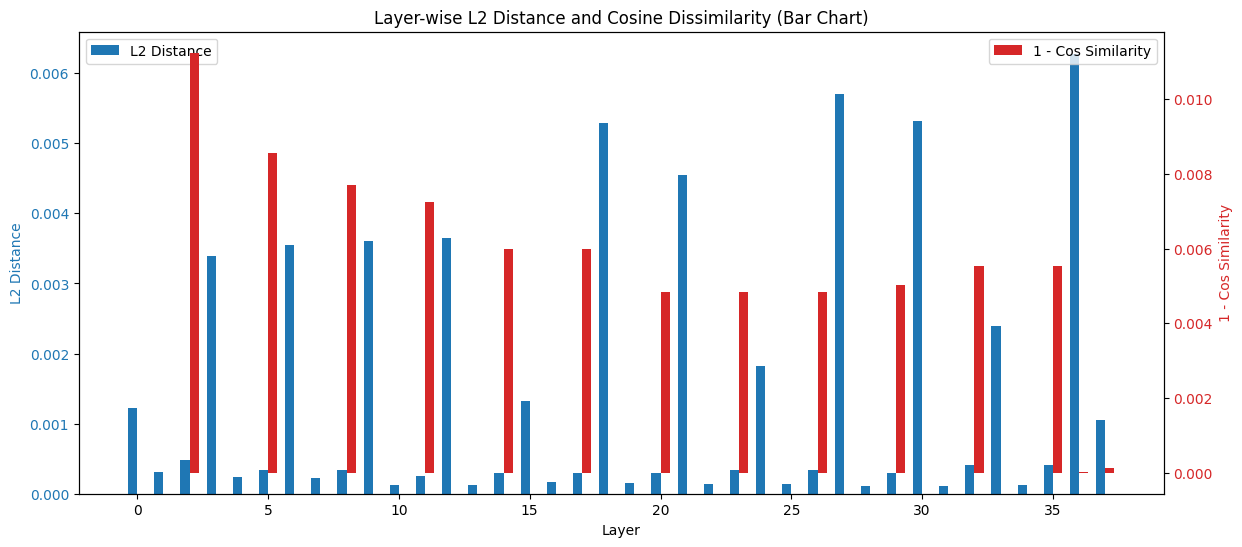

In [150]:
compare_model_weights(model1, model2)

The L2 and Cosine distince is small in this attack

In [127]:
import torch.nn as nn

# Example model
model = nn.Sequential(
    nn.Linear(10, 5),
    nn.BatchNorm1d(5),  # This has buffers (running_mean, running_var) in state_dict but not in parameters
    nn.Linear(5, 2)
)

# Get parameter names (those in model.parameters())
param_names = {name for name, param in model.named_parameters()}

# Filter state_dict keys that are in param_names
filtered_state_dict = {k: v for k, v in model.state_dict().items() if k in param_names}

# Display results
print(filtered_state_dict.keys())  # Only includes layers that are in model.parameters()


dict_keys(['0.weight', '0.bias', '1.weight', '1.bias', '2.weight', '2.bias'])
